- 출처 : https://tutorials.pytorch.kr/beginner/dcgan_faces_tutorial.html

#### 1. 초기설정 : 모델 import 및 데이터 로드

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import random


import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # 결과 재현을 위해 필요합니다

Random Seed:  999


In [79]:
# 데이터셋의 경로
dataroot = "data/MNIST"

# dataloader에서 사용할 쓰레드 수
workers = 4

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 28

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 1

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 학습할 에폭 수
num_epochs = 20

# 옵티마이저의 학습률
G_lr = 0.0004
D_lr = 0.0001

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

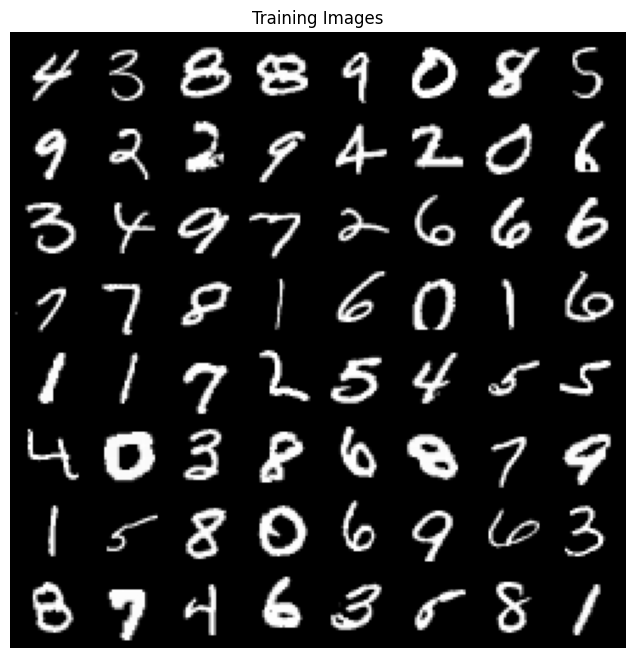

In [80]:
# dataloader를 정의해봅시다
batch_size = 128
image_size = 28
channels = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

#### 2. 모델 관련된 정의 (가중치초기화, optimizer)

In [81]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def weights_init_he(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

In [82]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, momentum=0.2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, image_size * image_size * channels),
            nn.Tanh()
        )
        self.latent_dim = latent_dim
    def forward(self, z):
        out = self.model(z)
        out = out.view(z.size(0), channels, image_size, image_size)
        return out

In [83]:
# 생성자를 만듭니다
netG = Generator(nz).to(device)

netG.apply(weights_init_he)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)


In [84]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

In [85]:
# 생성자를 만듭니다
netD = Discriminator().to(device)

# netD.apply(weights_init_he)
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


#### 2.5 옵티마이저 초기화

In [86]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(16, nz, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=4e-4, betas=(beta1, 0.999))

In [87]:
# https://github.com/juntang-zhuang/Adabelief-Optimizer?tab=readme-ov-file#installation-and-usage
from adabelief_pytorch import AdaBelief
optimizerG = AdaBelief(netG.parameters(), lr=1e-3, eps=1e-16, betas=(0.59,0.999), weight_decouple = True, rectify = True)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [88]:
# Add a learning rate scheduler for the optimizers https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
# schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=5, T_mult=1)
schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=5, T_mult=1)

#### 3. 학습 루프

In [89]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
G_losses_perEpoch = []
D_losses_perEpoch = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    g_losses_epoch = 0.0
    d_losses_epoch = 0.0
    for i, (data, _) in enumerate(train_loader):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data.to(device,non_blocking=True)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        # D_G_z1 -> 생성자 업데이트 후 D_G_z2
        if i % 50 == 0:
            print('[%02d/%d][%03d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        g_losses_epoch += errG.item()
        d_losses_epoch += errD.item()

    D_losses_perEpoch.append(d_losses_epoch / len(train_loader))
    G_losses_perEpoch.append(g_losses_epoch / len(train_loader))

    # Update the learning rate using the scheduler
    # schedulerD.step()
    # schedulerG.step()

Starting Training Loop...
[00/20][000/469]	Loss_D: 1.3550	Loss_G: 0.6824	D(x): 0.5294	D(G(z)): 0.5127 / 0.5055
[00/20][050/469]	Loss_D: 0.9096	Loss_G: 1.6210	D(x): 0.7010	D(G(z)): 0.4215 / 0.2000
[00/20][100/469]	Loss_D: 0.4604	Loss_G: 2.6381	D(x): 0.9067	D(G(z)): 0.2651 / 0.1518
[00/20][150/469]	Loss_D: 1.1547	Loss_G: 1.4465	D(x): 0.6241	D(G(z)): 0.4785 / 0.2491
[00/20][200/469]	Loss_D: 0.9657	Loss_G: 1.5728	D(x): 0.6829	D(G(z)): 0.4178 / 0.2230
[00/20][250/469]	Loss_D: 1.2767	Loss_G: 1.2005	D(x): 0.6298	D(G(z)): 0.5366 / 0.3176
[00/20][300/469]	Loss_D: 1.3711	Loss_G: 1.4991	D(x): 0.7322	D(G(z)): 0.6194 / 0.2702
[00/20][350/469]	Loss_D: 1.2899	Loss_G: 1.4751	D(x): 0.6507	D(G(z)): 0.5495 / 0.2574
[00/20][400/469]	Loss_D: 1.2051	Loss_G: 1.0328	D(x): 0.5769	D(G(z)): 0.4576 / 0.3765
[00/20][450/469]	Loss_D: 1.1935	Loss_G: 0.7911	D(x): 0.4723	D(G(z)): 0.3315 / 0.4787
[01/20][000/469]	Loss_D: 1.3467	Loss_G: 1.5079	D(x): 0.7467	D(G(z)): 0.6416 / 0.2419
[01/20][050/469]	Loss_D: 1.2546	Loss_G:

BCE 기반 GAN 기준에서:

errD 이론 기준: 1.386

errG 이론 기준: 0.693

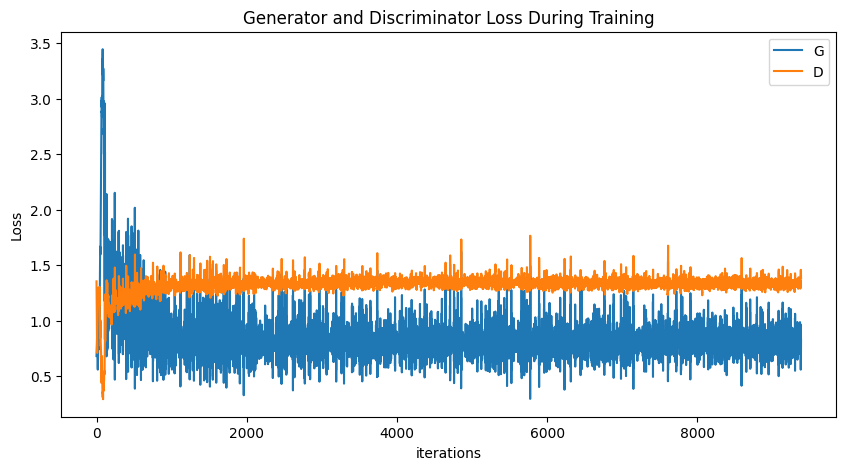

In [90]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [95]:
print(D_losses[-1])
print(G_losses[-1])

1.385904312133789
0.8295397162437439


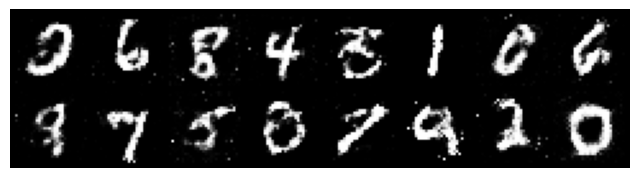

In [92]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

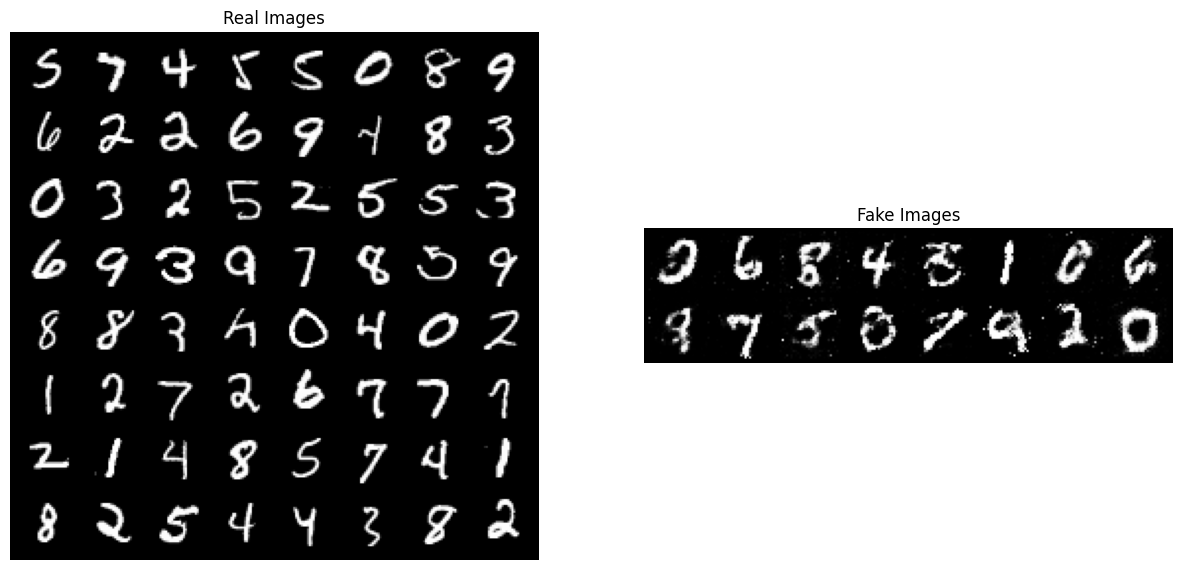

In [93]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(train_loader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

| 항목       | 정상 범위      | 내 값        |
| -------- | ---------- | ---------- | 
| mean     | -0.2 ~ 0.2 | **-0.716** | 
| mean std | 0.2 ~ 0.5  | **0.084**  | 


Generator Output Mean (per image): -0.7146
Generator Output Std Dev (per image): 0.0854


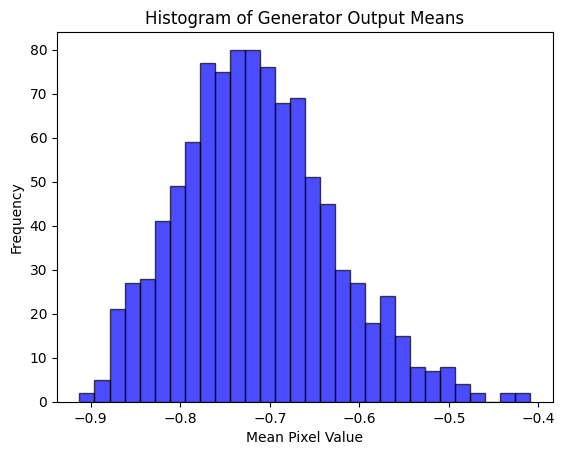

In [94]:
# Check the output distribution of the Generator
with torch.no_grad():
    noise = torch.randn(1000, nz, device=device)  # Generate a large batch of noise
    generated_images = netG(noise).view(1000, -1)  # Flatten the images
    output_means = generated_images.mean(dim=1).cpu().numpy()  # Compute mean per image
    output_overall_mean = output_means.mean()  # Overall mean
    output_overall_std = output_means.std()  # Overall standard deviation
    print(f"Generator Output Mean (per image): {output_overall_mean:.4f}")
    print(f"Generator Output Std Dev (per image): {output_overall_std:.4f}")
    plt.hist(output_means, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Histogram of Generator Output Means")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Frequency")
    plt.show()